In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import os

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
metadata_path = 'C:/Users/sheyn/Python notebook/data/last/cifar-100-python/meta' # change this path`\
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))
superclass_dict

{0: b'aquatic_mammals',
 1: b'fish',
 2: b'flowers',
 3: b'food_containers',
 4: b'fruit_and_vegetables',
 5: b'household_electrical_devices',
 6: b'household_furniture',
 7: b'insects',
 8: b'large_carnivores',
 9: b'large_man-made_outdoor_things',
 10: b'large_natural_outdoor_scenes',
 11: b'large_omnivores_and_herbivores',
 12: b'medium_mammals',
 13: b'non-insect_invertebrates',
 14: b'people',
 15: b'reptiles',
 16: b'small_mammals',
 17: b'trees',
 18: b'vehicles_1',
 19: b'vehicles_2'}

In [4]:
data_pre_path = 'C:/Users/sheyn/Python notebook/data/last/cifar-100-python/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
X_train_20 = data_train_dict[b'data']
y_train_20 = np.array(data_train_dict[b'coarse_labels'])
X_test_20 = data_test_dict[b'data']
y_test_20 = np.array(data_test_dict[b'coarse_labels'])

In [5]:
(X_train_100, y_train_100), (X_test_100, y_test_100) = keras.datasets.cifar100.load_data()

In [6]:
y_train_20 = tf.one_hot(y_train_20, 
                     depth=y_train_20.max() + 1, 
                     dtype=tf.float64) 
y_test_20 = tf.one_hot(y_test_20, 
                   depth=y_test_20.max() + 1, 
                   dtype=tf.float64) 
  
y_train_20 = tf.squeeze(y_train_20) 
y_test_20 = tf.squeeze(y_test_20) 

X_train_20 = X_train_20.reshape(-1, 32, 32, 3)
X_test_20 = X_test_20.reshape(-1, 32, 32, 3)

#### y_train_20 = tf.one_hot(y_train_20, depth=y_train_20.max() + 1, dtype=tf.float64) и y_test_20 = tf.one_hot(y_test_20, depth=y_test_20.max() + 1, dtype=tf.float64): 

Эти строки кода выполняют one-hot кодирование меток классов. В исходных данных метки представляют собой целые числа (например, от 0 до 19), которые указывают на принадлежность объекта к одному из 20 классов. One-hot кодирование преобразует каждую метку в вектор с нулями и одной единицей, которая указывает на класс объекта. Например, метка 3 будет преобразована в [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]. Это необходимо для обучения модели, так как она ожидает на входе такой формат меток.

#### y_train_20 = tf.squeeze(y_train_20) и y_test_20 = tf.squeeze(y_test_20):

После one-hot кодирования меток могут получиться лишние измерения. Функция tf.squeeze удаляет измерения с размером 1, чтобы привести метки к правильной форме, с которой может работать модель.

#### X_train_20 = X_train_20.reshape(-1, 32, 32, 3) и X_test_20 = X_test_20.reshape(-1, 32, 32, 3):

Эти строки кода изменяют форму данных (изображений). Исходные данные представляют собой одномерные массивы (например, 32x32x3), но для сверточной нейронной сети необходима трехмерная форма с размерностью (высота, ширина, количество каналов). Поэтому данные изменяют форму, чтобы привести их к нужному формату.

In [7]:
model = tf.keras.models.Sequential([ 
    layers.Conv2D(16, (3, 3), activation='relu', 
                  input_shape=(32, 32, 3), padding='same'), 
    layers.Conv2D(32, (3, 3), 
                  activation='relu', 
                  padding='same'), 
    layers.Conv2D(64, (3, 3), 
                  activation='relu', 
                  padding='same'), 
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(128, (3, 3), 
                  activation='relu', 
                  padding='same'), 
  
  
    layers.Flatten(), 
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dense(256, activation='relu'), 
    layers.Dropout(0.3), 
    layers.BatchNormalization(), 
    layers.Dense(20, activation='softmax') 
]) 
  
model.compile( 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['AUC', 'accuracy'] 
) 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                        

Обе модели имеют сходную архитектуру, начиная с сверточных слоев и заканчивая полносвязными слоями.

#### Слой Conv2D:

Это сверточный слой, который выполняет операции свертки на входных изображениях. Он использует окно размером 3x3 для извлечения признаков из изображения. Параметр activation='relu' указывает на использование функции активации ReLU после свертки.

#### Слой MaxPooling2D:

После нескольких сверточных слоев идет слой пулинга. Он уменьшает размерность данных и выделяет наиболее важные признаки, помогая уменьшить вычислительную сложность.

#### Слой Flatten:

Этот слой преобразует данные из многомерной структуры в одномерную, подготавливая их к подаче на полносвязные слои.

#### Слой BatchNormalization:

Это слой нормализации батча (Batch Normalization), который обычно используется в сверточных нейронных сетях. Его целью является улучшение стабильности и ускорение обучения модели

#### Полносвязные слои (Dense):

Эти слои представляют собой обычные полносвязные слои нейронной сети. Первый Dense слой имеет 256 нейронов с функцией активации ReLU. Затем идут слои BatchNormalization для нормализации данных, Dropout для регуляризации, и окончательный полносвязный слой с числом выходных нейронов, соответствующим числу классов (20 или 100 в зависимости от модели). Этот слой использует функцию активации softmax, чтобы предсказать вероятности принадлежности объекта к каждому из классов.

#### Параметры модели:

После описания архитектуры модели показываются параметры, такие как количество параметров, которые можно обучать (trainable params) и необучаемых параметров (non-trainable params).

In [9]:
hist = model.fit(X_train_20, y_train_20, 
                 epochs=6, 
                 batch_size=64, 
                 verbose=1, 
                 validation_data=(X_test_20, y_test_20)) 

Epoch 1/6


C:\Users\sheyn\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 94s 118ms/step - loss: 2.5083 - auc: 0.7802 - accuracy: 0.2490 - val_loss: 2.7996 - val_auc: 0.7433 - val_accuracy: 0.1706
Epoch 2/6
782/782 [==============================] - 93s 119ms/step - loss: 2.3073 - auc: 0.8185 - accuracy: 0.2883 - val_loss: 3.4195 - val_auc: 0.6753 - val_accuracy: 0.1109
Epoch 3/6
782/782 [==============================] - 94s 120ms/step - loss: 2.1889 - auc: 0.8402 - accuracy: 0.3277 - val_loss: 2.3241 - val_auc: 0.8226 - val_accuracy: 0.2900
Epoch 4/6
782/782 [==============================] - 96s 122ms/step - loss: 1.9940 - auc: 0.8720 - accuracy: 0.3822 - val_loss: 2.0796 - val_auc: 0.8622 - val_accuracy: 0.3793
Epoch 5/6
782/782 [==============================] - 93s 120ms/step - loss: 2.3438 - auc: 0.8117 - accuracy: 0.2762 - val_loss: 2.9971 - val_auc: 0.7252 - val_accuracy: 0.1597
Epoch 6/6
782/782 [==============================] - 92s 118ms/step - loss: 2.1156 - auc: 0.8533 - accuracy: 0.3471 - val_loss: 2.

In [10]:
y_test_20

<tf.Tensor: shape=(10000, 20), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])>

In [11]:
y_train_100 = tf.one_hot(y_train_100, 
                     depth=y_train_100.max() + 1, 
                     dtype=tf.float64) 
y_test_100 = tf.one_hot(y_test_100, 
                   depth=y_test_100.max() + 1, 
                   dtype=tf.float64) 
  
y_train_100 = tf.squeeze(y_train_100) 
y_test_100 = tf.squeeze(y_test_100) 

X_train_100 = X_train_100.reshape(-1, 32, 32, 3)
X_test_100 = X_test_100.reshape(-1, 32, 32, 3)

In [12]:
y_test_100

<tf.Tensor: shape=(10000, 100), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [13]:
model_2 = tf.keras.models.Sequential([ 
    layers.Conv2D(16, (3, 3), activation='relu', 
                  input_shape=(32, 32, 3), padding='same'), 
    layers.Conv2D(32, (3, 3), 
                  activation='relu', 
                  padding='same'), 
    layers.Conv2D(64, (3, 3), 
                  activation='relu', 
                  padding='same'), 
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(128, (3, 3), 
                  activation='relu', 
                  padding='same'), 
  
  
    layers.Flatten(), 
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dense(256, activation='relu'), 
    layers.Dropout(0.3), 
    layers.BatchNormalization(), 
    layers.Dense(100, activation='softmax') 
]) 
  
model_2.compile( 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['AUC', 'accuracy'] 
) 

In [14]:
hist_2 = model_2.fit(X_train_100, y_train_100, 
                 epochs=6, 
                 batch_size=64, 
                 verbose=1, 
                 validation_data=(X_test_100, y_test_100)) 

Epoch 1/6
782/782 [==============================] - 94s 119ms/step - loss: 3.9051 - auc: 0.7854 - accuracy: 0.1127 - val_loss: 6.1921 - val_auc: 0.6196 - val_accuracy: 0.0683
Epoch 2/6
782/782 [==============================] - 92s 118ms/step - loss: 3.1640 - auc: 0.8800 - accuracy: 0.2258 - val_loss: 2.9715 - val_auc: 0.8938 - val_accuracy: 0.2667
Epoch 3/6
782/782 [==============================] - 92s 118ms/step - loss: 2.6970 - auc: 0.9154 - accuracy: 0.3186 - val_loss: 5.0701 - val_auc: 0.7297 - val_accuracy: 0.1189
Epoch 4/6
782/782 [==============================] - 92s 117ms/step - loss: 2.4974 - auc: 0.9270 - accuracy: 0.3584 - val_loss: 3.1510 - val_auc: 0.8696 - val_accuracy: 0.2632
Epoch 5/6
782/782 [==============================] - 92s 117ms/step - loss: 2.6611 - auc: 0.9157 - accuracy: 0.3280 - val_loss: 2.8868 - val_auc: 0.8909 - val_accuracy: 0.3148
Epoch 6/6
782/782 [==============================] - 92s 117ms/step - loss: 2.2112 - auc: 0.9434 - accuracy: 0.4204 - va

In [15]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                      

In [19]:
from sklearn.metrics import classification_report

# Получение предсказаний
y_pred_20 = model.predict(X_test_20)
y_pred_100 = model_2.predict(X_test_100)

# Оценка результатов
classification_report_20 = classification_report(np.argmax(y_test_20, axis=1), np.argmax(y_pred_20, axis=1))
classification_report_100 = classification_report(np.argmax(y_test_100, axis=1), np.argmax(y_pred_100, axis=1))

print("Classification Report for 20 Classes Model:")
print(classification_report_20)

313/313 [==============================] - 4s 13ms/step
Classification Report for 20 Classes Model:
              precision    recall  f1-score   support

           0       0.45      0.27      0.34       500
           1       0.40      0.27      0.32       500
           2       0.75      0.38      0.50       500
           3       0.16      0.60      0.26       500
           4       0.42      0.46      0.44       500
           5       0.19      0.32      0.24       500
           6       0.24      0.52      0.33       500
           7       0.55      0.20      0.30       500
           8       0.27      0.12      0.17       500
           9       0.49      0.34      0.41       500
          10       0.47      0.73      0.57       500
          11       0.32      0.26      0.29       500
          12       0.28      0.27      0.27       500
          13       0.25      0.04      0.07       500
          14       0.36      0.37      0.36       500
          15       0.26      0.03  

In [20]:
print("Classification Report for 100 Classes Model:")
print(classification_report_100)

Classification Report for 100 Classes Model:
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       100
           1       0.40      0.61      0.49       100
           2       0.23      0.22      0.23       100
           3       0.22      0.11      0.15       100
           4       0.11      0.08      0.09       100
           5       0.41      0.32      0.36       100
           6       0.45      0.30      0.36       100
           7       0.40      0.32      0.35       100
           8       0.72      0.48      0.57       100
           9       0.87      0.45      0.59       100
          10       0.44      0.17      0.24       100
          11       0.26      0.23      0.24       100
          12       0.54      0.44      0.49       100
          13       0.60      0.25      0.35       100
          14       0.25      0.48      0.33       100
          15       0.26      0.19      0.22       100
          16       0.80      0.24   

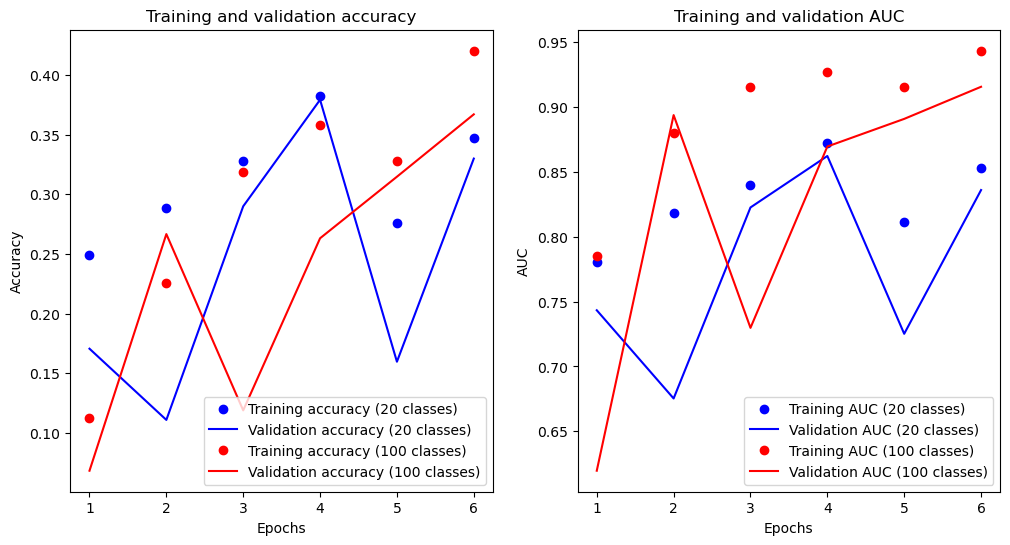

In [27]:
import matplotlib.pyplot as plt

# Построение графиков точности
epochs = range(1, 7)  # 6 эпох

# Точность для модели с 20 классами
accuracy_20 = hist.history['accuracy']
val_accuracy_20 = hist.history['val_accuracy']

# Точность для модели с 100 классами
accuracy_100 = hist_2.history['accuracy']
val_accuracy_100 = hist_2.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_20, 'bo', label='Training accuracy (20 classes)')
plt.plot(epochs, val_accuracy_20, 'b', label='Validation accuracy (20 classes)')
plt.plot(epochs, accuracy_100, 'ro', label='Training accuracy (100 classes)')
plt.plot(epochs, val_accuracy_100, 'r', label='Validation accuracy (100 classes)')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График AUC
auc_20 = hist.history['auc']
val_auc_20 = hist.history['val_auc']
auc_100 = hist_2.history['auc']
val_auc_100 = hist_2.history['val_auc']

plt.subplot(1, 2, 2)
plt.plot(epochs, auc_20, 'bo', label='Training AUC (20 classes)')
plt.plot(epochs, val_auc_20, 'b', label='Validation AUC (20 classes)')
plt.plot(epochs, auc_100, 'ro', label='Training AUC (100 classes)')
plt.plot(epochs, val_auc_100, 'r', label='Validation AUC (100 classes)')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

В ходе сравнения двух моделей, одной с 20 классами и другой с 100 классами, было обнаружено, что модель с 100 классами продемонстрировала незначительное увеличение итоговой AUC и точности по сравнению с моделью с 20 классами.

Существуют несколько потенциальных объяснений для этого увеличения:

##### Улучшенная обобщающая способность: Включение дополнительных классов может помочь модели лучше выявлять общие паттерны в данных, что, в свою очередь, может повысить ее способность обобщения.

##### Более эффективная регуляризация: Дополнительные классы могут действовать как дополнительный вид регуляризации, предотвращая переобучение и способствуя улучшению качества модели.

##### Лучшая инициализация: Возможно, модель с 100 классами имела более подходящую инициализацию весов или начальную архитектуру, способствующую более успешному обучению.

Тем не менее, стоит отметить, что разница между моделями небольшая, и в реальных прикладных задачах следует учитывать и другие факторы при выборе между ними. Дополнительные классы также требуют больше вычислительных ресурсов и времени на обучение, что также может оказаться важным фактором в принятии решения.